In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [254]:
import ast

import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from scipy.stats import gaussian_kde

from shared_astro_utils import matching_utils

### Load Catalogs

In [6]:
!pwd

/Data/repos/zoobot/analysis


In [9]:
mhc_loc = '../data/mhc/ZOO_model_full_catalogue.fit'

In [46]:
mhc_catalog = Table.read(mhc_loc)

In [47]:
mhc_catalog['dr7objid'] = [str(x) for x in mhc_catalog['dr7objid']]

In [48]:
mhc_catalog = mhc_catalog.to_pandas()

In [24]:
gz_catalog_loc = '/data/galaxy_zoo/gz2/catalogs/basic_regression_labels_with_bars.csv'

In [56]:
gz_catalog = pd.read_csv(gz_catalog_loc, dtype={'dr7objid': str})

### Check Data

In [49]:
mhc_catalog.iloc[0]

dr7objid        587722952230174996
galcount                         1
P_disk                 3.54431e-05
P_edge_on                 0.646749
P_bar_GZ2               0.00570267
P_bulge                 0.00223408
P_cigar                   0.992602
P_merg                   0.0210895
P_bar_Nair10              0.384967
TT_pred                    3.40424
P_S0                      0.970816
Name: 0, dtype: object

In [57]:
gz_catalog.iloc[0]

dr7objid                                                                                        587732591714893851
ra_subject                                                                                                 179.043
dec_subject                                                                                                60.5225
total_classifications                                                                                           45
total_votes                                                                                                    342
t01_smooth_or_features_a01_smooth_count                                                                          0
t01_smooth_or_features_a01_smooth_weighted_fraction                                                              0
t01_smooth_or_features_a02_features_or_disk_count                                                               42
t01_smooth_or_features_a02_features_or_disk_weighted_fraction                   

### Merge

In [63]:
assert type(gz_catalog.iloc[0]['dr7objid']) == type(mhc_catalog.iloc[0]['dr7objid']) == str

In [60]:
df = pd.merge(gz_catalog, mhc_catalog, on='dr7objid', how='inner')

In [61]:
len(gz_catalog), len(mhc_catalog), len(df)

(239695, 670722, 234795)

### Filter to current shard galaxies

In [72]:
df['bar_total-votes'] = df['t03_bar_a06_bar_count'] + df['t03_bar_a07_no_bar_count']
df['bar_fraction'] = df['t03_bar_a06_bar_count'] / df['bar_total-votes']
df = df[df['bar_total-votes'] > 10]
len(df)

73354

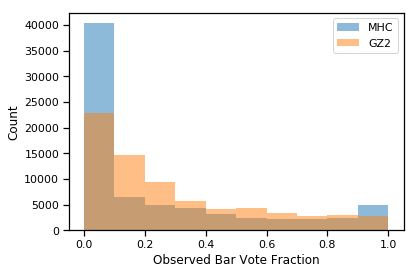

In [92]:
fig, ax = plt.subplots()
alpha = 0.5
ax.hist(df['P_bar_GZ2'], alpha=alpha)
ax.hist(df['bar_fraction'], alpha=alpha)
ax.set_xlabel('Observed Bar Vote Fraction')
ax.set_ylabel('Count')
ax.legend(['MHC', 'GZ2'])

### Baseline

rmse is not really the right thing to measure, but it'll do

In [107]:
clf = DummyRegressor()
train_df, test_df = df[:50000], df[50000:]
X_train = np.random.rand(len(train_df), 1)
X_test = np.random.rand(len(test_df), 1)
Y_train = train_df['bar_fraction']
Y_test = test_df['bar_fraction']

clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(Y_test, predictions))
rmse  

0.2607518098536792

### Compare Against Nair (appeal to expert)

DS trained on GZ2 with 0.2 or 0.8 prob, and n total votes > 5 ('high confidence sample')

DS trained on Nair with all bars, initializing from trained GZ model.

Should be able to do something like: 

Regress GZ2 to Nair to predict strong bars
Ask model to predict strong bars
Compare to DS predictions of strong bars

Should first check how many strong bars - only 24??

In [109]:
nair_loc = '/data/galaxy_zoo/decals/catalogs/nair_sdss_catalog_interpreted.csv'
nair_df = pd.read_csv(nair_loc)

In [112]:
nair_df.iloc[0]

iauname        J155341.74-003422.84
zs                            0.078
q_zs                              1
g_mag                         15.82
r_mag                        15.058
log_m_                       11.083
age                           4.459
b_a                           0.794
sigma                        143.68
tt                                3
bar                               0
ring                             36
f_ring                            0
lens                              0
ttq                               0
pair                              0
f_pair                            0
int                               0
nt                                0
rc3                                
ra                          238.424
dec                       -0.573011
has_bar                       False
has_ring                       True
bar_types                        []
ring_types    ['inner', 'min_four']
Name: 0, dtype: object

In [198]:
nair_df['has_strong_bar'].sum(), nair_df['has_bar'].sum()

(210, 2612)

In [114]:
nair_df['bar_types'] = nair_df['bar_types'].apply(ast.literal_eval)

In [130]:
nair_df['has_strong_bar'] = ['strong' in bars for bars in nair_df['bar_types']]

In [132]:
matched, unmatched = matching_utils.match_galaxies_to_catalog_pandas(
    galaxies=nair_df,
    catalog=df,
    galaxy_suffix='_nair'
)

In [133]:
len(matched), len(unmatched)  # seems a bit low, no?

(6051, 7983)

In [134]:
sum(['strong' in bars for bars in matched['bar_types']])

142

#### Typical GZ2 Bar Fractions (for interest only)

In [252]:
# fig, ax = plt.subplots()
# has_strong_bar = matched[matched['has_strong_bar']]['bar_fraction']
# no_strong_bar = matched[~matched['has_strong_bar']]['bar_fraction']
# strong_kde = gaussian_kde(has_strong_bar)
# no_strong_kde = gaussian_kde(no_strong_bar)
# x = np.linspace(0., 1., 300)
# plt.plot(x, strong_kde(x), label='nair: strong bar')
# plt.plot(x, no_strong_kde(x), label='nair: not strong bar')
# ax.set_xlabel('GZ2 Bar Fraction')
# ax.set_ylabel('Prob. Dens. of Having Bar Fraction')

Text(0,0.5,'Prob. Dens. of Having Bar Fraction')

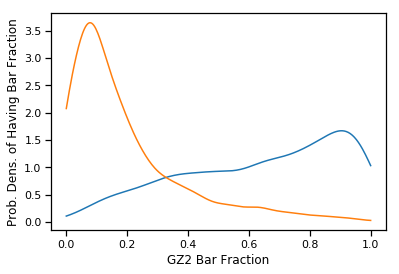

In [200]:
fig, ax = plt.subplots()
has_bar = matched[matched['has_bar']]['bar_fraction']
no_bar = matched[~matched['has_bar']]['bar_fraction']
bar_kde = gaussian_kde(has_bar)
no_bar_kde = gaussian_kde(no_bar)
x = np.linspace(0., 1., 300)
plt.plot(x, bar_kde(x), label='nair: strong bar')
plt.plot(x, no_bar_kde(x), label='nair: not strong bar')
ax.set_xlabel('GZ2 Bar Fraction')
ax.set_ylabel('Prob. Dens. of Having Bar Fraction')

### Predict Nair from GZ2 Votes (WWND) with Logistic Regression

In [256]:
train_df, test_df = train_test_split(matched, test_size=0.2, stratify=matched['has_bar'])

In [249]:
# strong_clf = LogisticRegression()
# strong_clf.fit(matched['bar_fraction'].values.reshape(-1, 1), matched['has_strong_bar'])
# strong_predictions = strong_clf.predict_proba(matched['bar_fraction'].values.reshape(-1, 1))[:, 1]
# sns.scatterplot(matched['bar_fraction'].values, predictions)
# gz2_expected_strong_bars = sum(strong_predictions)
# print(gz2_expected_strong_bars)

Expected bars: 389.6 Actual bars: 379


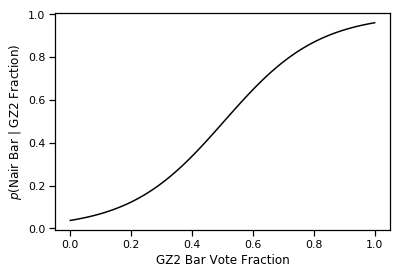

In [480]:
bar_clf = LogisticRegression()
bar_clf.fit(train_df['bar_fraction'].values.reshape(-1, 1), train_df['has_bar'])

def p_bar_given_gz(bar_fractions): return bar_clf.predict_proba(bar_fractions.values.reshape(-1, 1))[:, 1]

# sns.scatterplot(train_df['bar_fraction'].values, p_bar_given_gz(train_df['bar_fraction']))
fig, ax = plt.subplots()
x = pd.Series(np.linspace(0., 1., 100))
ax.plot(x, p_bar_given_gz(x), 'k')
ax.set_xlabel('GZ2 Bar Vote Fraction')
ax.set_ylabel(r'$p$(Nair Bar | GZ2 Fraction)')
plt.savefig('/data/repos/latex/active_learning/figures/gz2_fraction_to_nair_latest.png')

gz2_predictions = p_bar_given_gz(test_df['bar_fraction'])

# should be similar total num. of expected/observed bars if predict_proba is well-calibrated
gz2_expected_bars = np.sum(gz2_predictions)
print('Expected bars: {:.1f} Actual bars: {:.0f}'.format(gz2_expected_bars, test_df['has_bar'].sum()))

In [262]:
sum(test_df['P_bar_Nair10']), sum(test_df['P_bar_GZ2'])

(556.8049664699397, 360.5580656315142)

Next question: how can you do using the probabilistic model predictions? Hopefully, about as well as with GZ2 predictions but including a window of uncertainty.

In [ ]:
# from zoobot...

In [279]:
 # samples from model for gz2 mean bar votes
gz2_dl_rho_predictions = np.random.rand(len(test_df), 10)

# need to implement this for varied n_votes
n_votes = 10
# gz2_dl_probs = bin_probs_of_samples(gz2_dl_predictions, n_votes=n_votes).mean(axis=1)  # reduce over forward passes
gz2_dl_probs = np.ones((len(test_df), n_votes)) / n_votes

In [282]:
# bootstrap sample for distribution of bar probabilities
n_samples = 100
votes = np.zeros((len(test_df), n_samples))
for galaxy_n in range(len(test_df)):
    for sample_n in range(n_samples):
        votes[galaxy_n, sample_n] = np.random.choice(
            list(range(n_votes)),
            p=gz2_dl_probs[galaxy_n, :]
        )

In [283]:
votes

array([[4., 2., 7., ..., 9., 0., 6.],
       [7., 8., 1., ..., 6., 6., 7.],
       [7., 1., 1., ..., 7., 4., 5.],
       ...,
       [0., 0., 9., ..., 7., 8., 1.],
       [4., 4., 6., ..., 1., 5., 8.],
       [9., 2., 9., ..., 2., 4., 3.]])

In [285]:
votes_data = []
for galaxy_n in range(len(votes)):
    for sample_n in range(n_samples):
        votes_data.append(
            {'galaxy': galaxy_n, 'sample': sample_n, 'votes': votes[galaxy_n, sample_n]}
        )
votes_df = pd.DataFrame(data=votes_data)

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


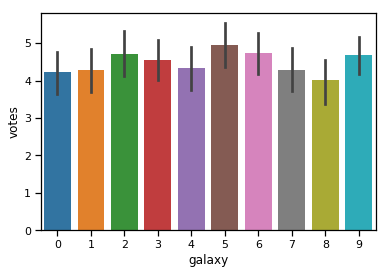

In [288]:
df = votes_df[votes_df['galaxy'] < 10]
sns.barplot(data=df, x='galaxy', y='votes')

In [289]:
vote_fractions = votes / n_votes

Text(0,0.5,'True Positive Rate')

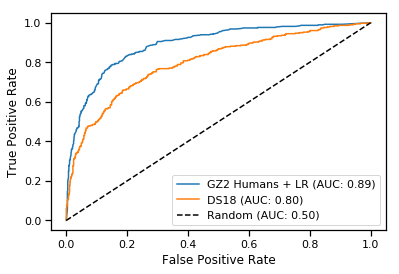

In [478]:
ds_n_predictions = test_df['P_bar_Nair10']  # model trained on Nair to predict Nair
ds_g_predictions = test_df['P_bar_GZ2'] # model trained on GZ2 to predict barredness

fpr_gz2, tpr_gz2, _ = metrics.roc_curve(test_df['has_bar'], gz2_predictions)
auc_gz2 = metrics.roc_auc_score(test_df['has_bar'], gz2_predictions)

fpr_ds_n, tpr_ds_n, _ = metrics.roc_curve(test_df['has_bar'], ds_n_predictions)
auc_ds_n = metrics.roc_auc_score(test_df['has_bar'], ds_n_predictions)

# fpr_ds_g, tpr_ds_g, _ = metrics.roc_curve(test_df['has_bar'], ds_g_predictions)
# auc_ds_g = metrics.roc_auc_score(test_df['has_bar'], ds_g_predictions)

dl_bar_predictions.sum()

fig, ax = plt.subplots()
ax.plot(fpr_gz2, tpr_gz2, label='GZ2 Humans + LR (AUC: {:.2f})'.format(auc_gz2))
ax.plot(fpr_ds_n, tpr_ds_n, label='DS18 (AUC: {:.2f})'.format(auc_ds_n))
# ax.plot(fpr_ds_g, tpr_ds_g, label='DS18-G (AUC: {:.2f})'.format(auc_ds_g))
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC: 0.50)')
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

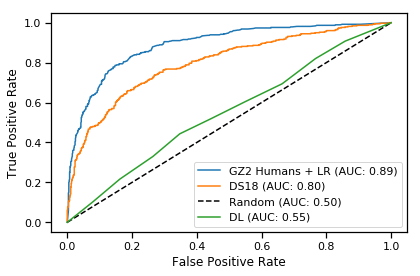

In [479]:

fpr_dl, tpr_dl, _ = metrics.roc_curve(test_df['has_bar'], dl_bar_predictions)  # actually defined later
auc_dl = metrics.roc_auc_score(test_df['has_bar'], dl_bar_predictions)
ax.plot(fpr_dl, tpr_dl, label='DL (AUC: {:.2f})'.format(auc_dl))
ax.legend()
fig.tight_layout()
fig.savefig('/data/repos/latex/active_learning/figures/nair_bar_roc.png')
fig

correct: 90% of unbarred, 80% of strong barred?

In [396]:
from sklearn.metrics import confusion_matrix

In [399]:
confusion_matrix(test_df['has_bar'], ds_n_predictions > 0.5) / len(test_df['has_bar'])

array([[0.54582989, 0.14120562],
       [0.10487201, 0.20809249]])

You can do a much better job predicting what Nair would have said (bar/no bar) using the GZ2 bar fraction + logistic regression than using the 'improved' DS catalog.

DS doesn't report the train/test split - we'll have to ignore that for now, and perhaps send an email.

- matched_train -> fit logistic regression WWND
- matched_test -> how well can we predict what Nair would have said, using gz2 votes?
- matched_test -> how well does ds predict what Nair would have said
- matched_test + dl -> how well can we predict what Nair would have said, using gz2 dl-inferred votes?

(matched = gz2 + nair intersection

In [307]:
from zoobot.uncertainty import dropout_calibration

dl_bar_predictions_all = np.stack([
    p_bar_given_gz(pd.Series(vote_fractions[:, n])) for n in range(vote_fractions.shape[1])],
    axis=1
)



In [308]:
dl_bar_predictions_all.shape

(1211, 100)

This is a good thing to do, but should be for value of posteriors not for DL comparison - DS didn't publish GZ estimates.
But maybe someone else did? Would make life much easier!

In [350]:
test_df['log_m_'].sample(10)

4797    11.159
1572    11.001
2763    10.652
108     10.972
1307     9.019
2731    11.115
1285    10.325
4170    11.254
5872    10.081
137      9.568
Name: log_m_, dtype: float64

In [352]:
dl_bar_predictions_all[:, 0]

array([0.33699113, 0.77775472, 0.77775472, ..., 0.03735516, 0.33699113,
       0.92682225])

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


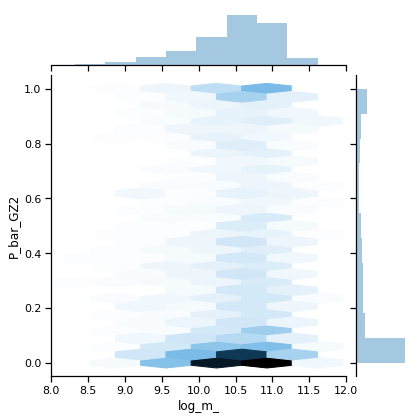

In [363]:
ax = sns.jointplot(test_df['log_m_'], ds_g_predictions, xlim=[8, 12], kind='hex')

In [385]:
df = test_df[(8 < test_df['log_m_']) &  (test_df['log_m_'] < 12)]

In [386]:
galaxies, bins = np.histogram(df['log_m_'])
bars, _ = np.histogram(df[df['has_bar']]['log_m_'], bins=bins)

In [389]:
def get_bin_centers(bins):
    return [np.mean(bin_pair) for bin_pair in zip(bins[:-1], bins[1:])]

<ErrorbarContainer object of 3 artists>

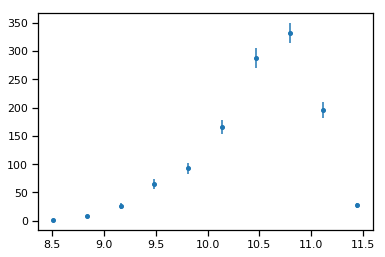

In [394]:
plt.errorbar(get_bin_centers(bins), values, yerr=np.sqrt(galaxies), fmt='o', markersize=4)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(test_df['log_m_'], dl_bar_predictions_all[:, 0])
ax.set_xlim([8, 12])

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


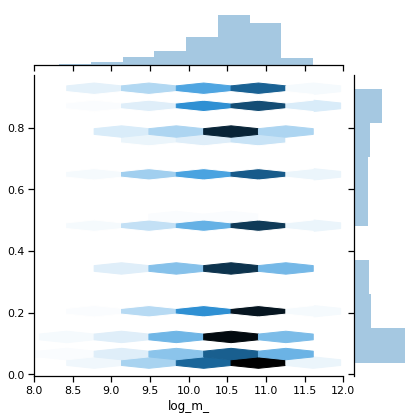

In [364]:
ax = sns.jointplot(test_df['log_m_'], dl_bar_predictions_all[:, 0], xlim=[8, 12], kind='hex')

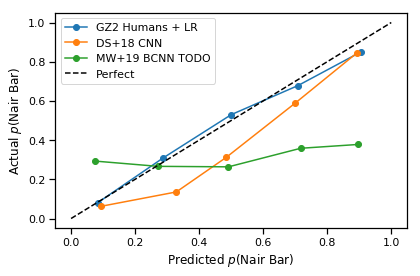

In [472]:
from sklearn.calibration import calibration_curve

fig, ax = plt.subplots()

n_bins = 5
marker = 'o'


prob_true, prob_pred = calibration_curve(test_df['has_bar'], gz2_predictions, n_bins=n_bins)
ax.plot(prob_pred, prob_true, label='GZ2 Humans + LR', marker=marker)

# prob_true, prob_pred = calibration_curve(test_df['has_bar'], ds_g_predictions, n_bins=n_bins)
# ax.plot(prob_pred, prob_true, label='g', marker=marker)

prob_true, prob_pred = calibration_curve(test_df['has_bar'], ds_n_predictions, n_bins=n_bins)
ax.plot(prob_pred, prob_true, label='DS+18 CNN', marker=marker)


prob_true, prob_pred = calibration_curve(test_df['has_bar'], dl_bar_predictions, n_bins=n_bins)
ax.plot(prob_pred, prob_true, label='MW+19 BCNN TODO', marker=marker)


ax.plot([0, 1], [0, 1], 'k--', label='Perfect')
ax.set_xlabel('Predicted $p$(Nair Bar)')
ax.set_ylabel('Actual $p$(Nair Bar)')
plt.legend()
fig.tight_layout()
fig.savefig('/data/repos/latex/active_learning/figures/ds_calibration_latest.png')

556.8049664699397

In [473]:
len(test_df)

1211

In [407]:
test_df['has_bar'].sum()

379

In [408]:
len(test)

389.61459944934404

           catalog  predicted_bars
0  GZ2 Humans + LR      389.614599
1            DS+18      556.804966
2  MW+19 BCNN TODO      517.886434


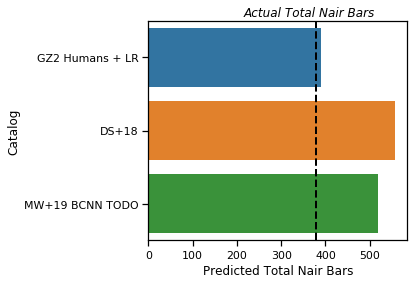

In [470]:
data = [
    {'catalog': 'GZ2 Humans + LR', 'predicted_bars': gz2_predictions.sum()},
    {'catalog': 'DS+18', 'predicted_bars': ds_n_predictions.sum()},
    {'catalog': 'MW+19 BCNN TODO', 'predicted_bars': dl_bar_predictions.sum()}
]
bar_totals_df = pd.DataFrame(data=data)
print(bar_totals_df)
fig, ax = plt.subplots()
sns.barplot(data=bar_totals_df, x='predicted_bars', y='catalog', ax=ax)
ax.set_ylabel('Catalog')
ax.set_xlabel('Predicted Total Nair Bars')
ax.axvline(test_df['has_bar'].sum(), linestyle='--', color='k', linewidth=2.)
ax.text(.62, 1.02, 'Actual Total Nair Bars', transform=ax.transAxes, horizontalalignment='center', fontstyle='italic')
fig.tight_layout()
fig.savefig('/data/repos/latex/active_learning/figures/ds_total_bars_latest.png')